In [103]:
def address(ticker, from_date="2025-01-01"):
    url = "https://financialmodelingprep.com/api/v3/historical-price-full/{}?from={}&apikey=968c869312f78f001e1db51db0039689"
    return url.format(ticker, from_date)

## Heston Model

$ \kappa (\theta - v_t)dt + \Epsilon \sqrt{v_t} dW_t^v  $ 

## SABR Model
$ \alpha_{t+1} = v \alpha_t dW_t$

## Garch Model

$ \sigma_t^2 = a_0 + a_1 \epsilon_{t-1}^2 + \beta_1 \sigma_{t-1}^2 $

$ \sigma_{t+1}^2 = a_0 + (a_1 + \beta_1) \sigma_{t}^2 $ 



In [ ]:
import requests 
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from connector import Database # IMPORT YOUR OWN DATABASE

In [105]:
conn, cursor = Database()

In [106]:
def ExtractAll(xu):
    return np.array([i[1:] for i in xu])

callprice = cursor.execute('SELECT * FROM dbo.callpremium')
callprice = np.array(callprice.fetchall())
callprice = ExtractAll(callprice)

conn.commit()

callvol = cursor.execute('SELECT * FROM dbo.calliv')
callvol = np.array(callvol.fetchall())
callvol = ExtractAll(callvol)

conn.commit()

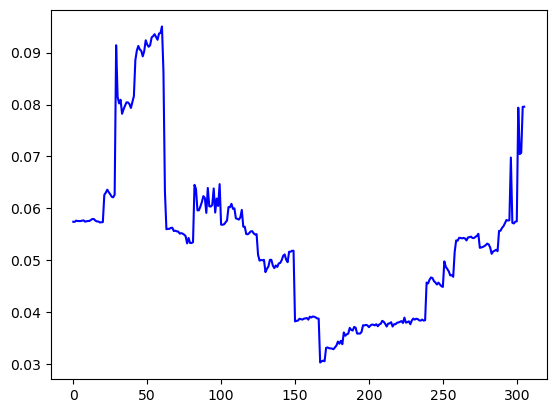

In [107]:
volt = []

for price, vol in zip(callprice, callvol):
    total = sum(price)
    weights = price / total
    iv = weights.T.dot(vol)
    volt.append(iv**2)

plt.plot(volt, color='blue')
plt.show()

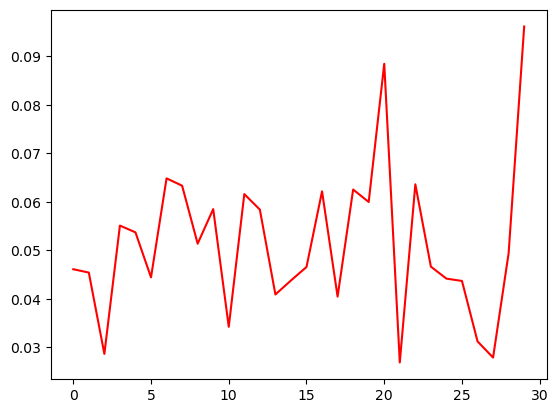

In [108]:
# Heston Model

t = 30.0/365.0
steps_heston = 300
dt_heston = t / steps_heston
paths_heston = 30

v0, v1 = volt[:-1], volt[1:]
top = sum([(i - np.mean(v0))*(j - np.mean(v1)) for i, j in zip(v0, v1)])
bot = sum([(i - np.mean(v1))**2 for i in v1])

kappa = -np.log(top / bot) / dt_heston
theta = np.mean(volt)
sigma = np.std(volt)

heston_forecast = []
for i in range(paths_heston):
    vol0 = volt[-1]
    dWT = np.random.randn(steps_heston)
    for t in range(steps_heston):
        vol0 += kappa*(theta - vol0)*dt_heston + sigma*np.sqrt(vol0)*dWT[t]
    heston_forecast.append(vol0)

plt.plot(heston_forecast, color='red')
plt.show()

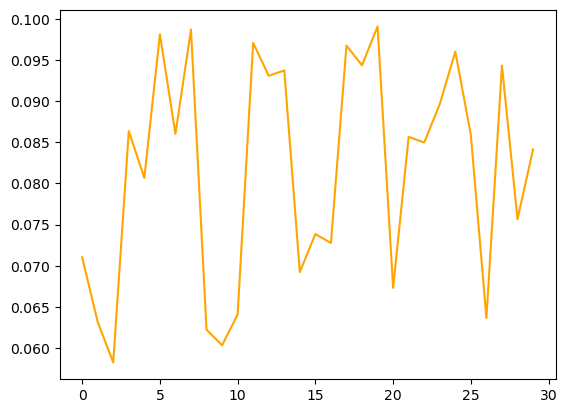

In [109]:
# SABR Model 

vofv = np.std(volt)
sabr_steps = 300
sabr_paths = 30

sabr_forecast = []
for i in range(sabr_paths):
    vs0 = volt[-1]
    dWT = np.random.randn(sabr_steps)
    for t in range(sabr_steps):
        vs0 += vofv*vs0*dWT[t]
    sabr_forecast.append(vs0)

plt.plot(sabr_forecast, color='orange')
    

In [110]:
prices = cursor.execute('SELECT * FROM dbo.prices')
prices = ExtractAll(prices)
prices = np.array(prices[:, 0], dtype=float)

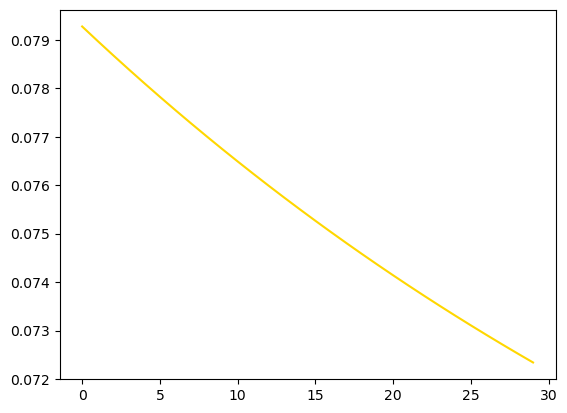

In [111]:
ror = prices[1:]/prices[:-1] - 1.0
ror2 = ror**2

vb0 = np.array(volt[:-1])
vb1 = np.array(volt[1:])

XHat = np.array([[1.0, i, j] for i, j in zip(ror2, vb0)])

coef = np.linalg.inv(XHat.T.dot(XHat)).dot(XHat.T.dot(vb1))

garch_forecast = []
vinit = vb1[-1]
for t in range(sabr_paths):
    vinit = coef[0] + coef[1]*ror2[-1] + coef[2]*vinit
    garch_forecast.append(vinit)

plt.plot(garch_forecast, color='gold')
plt.show()
    

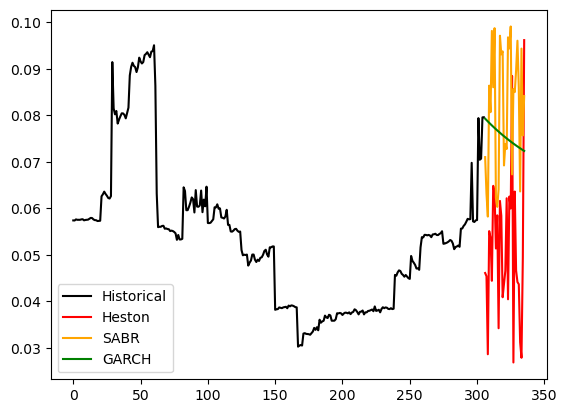

In [112]:
XX = list(range(len(volt)))
X2 = list(range(len(volt), len(volt)+sabr_paths))

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(XX, volt, color='black', label='Historical')
ax.plot(X2, heston_forecast, color='red', label='Heston')
ax.plot(X2, sabr_forecast, color='orange', label='SABR')
ax.plot(X2, garch_forecast, color='green', label='GARCH')
ax.legend()
plt.show()